In [5]:
from Triangulation import *

import torch
import torch.optim as optim

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F
%matplotlib inline


In [6]:
def compute_accuracy(net,x_variable,target_value):
  
    net.eval()
    prediction=net(variable)
    prediction=prediction.numpy()
    count=np.sum(prediction==target_value.numpy())    
    net.train()
    return count/x_variable.numpy().shape[0]
    

    

In [7]:
polygons=load_dataset('12_polygons.pkl')
nb_of_points=load_dataset('12_nb_of_points.pkl')

In [8]:
nb_of_points=nb_of_points[:431350]
polygons=polygons[:43135]

In [9]:
polygons=[i for i in polygons for j in range(10)]

In [10]:
polygons_reshaped=[]
for polygon in polygons:
    polygons_reshaped.append(polygon.reshape(1,2*12))

In [11]:
for index,polygon in enumerate(polygons_reshaped):
    if (index+1)%10==0:
        polygons_reshaped[index]=np.append(polygon,1)
    else:    
        polygons_reshaped[index]=np.append(polygon,((0.1*((index+1)%10))))

    

In [12]:
nb_of_points=[i[0] for i in nb_of_points]


In [13]:
nb_of_points=np.array(nb_of_points)
polygons_reshaped=np.array(polygons_reshaped)
polygons_reshaped.shape[0]

431350

In [14]:
nb_of_test_data=int(len(polygons_reshaped)*0.2)
nb_of_training_data=int(len(polygons_reshaped)-nb_of_test_data)


In [15]:
x_tensor=torch.from_numpy(polygons_reshaped[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(polygons_reshaped[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)

y_tensor=torch.from_numpy(nb_of_points[:nb_of_training_data]).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(nb_of_points[nb_of_training_data:]).type(torch.FloatTensor)
y_variable,y_variable_test=Variable(y_tensor),Variable(y_tensor_test)



In [16]:
B_INIT = -0.2 # use a bad bias constant initializer


class Net(nn.Module):
    
    def __init__(self,in_features_dimension,out_features_dimension,nb_of_hidden_layers,nb_of_hidden_nodes,
                 batch_normalization=False):
        
        super(Net,self).__init__()
        
        self.nb_hidden_layers=nb_of_hidden_layers
        self.do_bn=batch_normalization
        self.fcs=[]
        self.bns=[]
        self.bn_input=nn.BatchNorm1d(in_features_dimension,momentum=0.5) #for input data
        
        for i in range(nb_of_hidden_layers):                              # build hidden layers and BN layers
            
            input_size=in_features_dimension if i==0 else nb_of_hidden_nodes
            fc=nn.Linear(input_size,nb_of_hidden_nodes)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            
            if self.do_bn:
                bn = nn.BatchNorm1d(nb_of_hidden_nodes, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)                         # IMPORTANT set layer to the Module
                self.bns.append(bn)
    
            self.predict = nn.Linear(nb_of_hidden_nodes,out_features_dimension)         # output layer
            self._set_init(self.predict)                                              # parameters initialization
    
    
    def _set_init(self, layer):
            init.normal(layer.weight, mean=0., std=.1)
            init.constant(layer.bias, B_INIT)

    
    
    
    def forward(self, x):
        ACTIVATION=F.relu
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # input batch normalization
        layer_input = [x]
        for i in range(self.nb_hidden_layers):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out
        
    

In [17]:

my_net=Net(25,1,nb_of_hidden_layers=5,
           nb_of_hidden_nodes=50,batch_normalization=True)


In [18]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=1e-4)
#optimizer = torch.optim.SGD(my_net.parameters(), lr=1e-5,weight_decay=.5,momentum=0.9)

loss_func = torch.nn.MSELoss(size_average=False) 

In [19]:
if  torch.cuda.is_available():
    my_net.cuda()
    loss_func.cuda()
    x_variable , y_variable,x_variable_test,y_variable_test= x_variable.cuda(), y_variable.cuda(),x_variable_test.cuda(),y_variable_test.cuda()
    print("cuda activated")

cuda activated


In [20]:
nb_of_epochs=3000
batch_size=int(x_variable.shape[0]/40  )
# Train the network #
my_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    if t%10==0:
        my_net.eval()
        test_loss=loss_func(my_net(x_variable_test),y_variable_test).data[0]
        my_net.train()
        print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Epoch:",t,"Test Loss:",test_loss/x_variable_test.size(0))

Epoch: 0 Training Loss: 162.31195411208995 Epoch: 0 Test Loss: 161.03154051234498
Epoch: 10 Training Loss: 133.04454909006608 Epoch: 10 Test Loss: 130.99659209458676
Epoch: 20 Training Loss: 109.28289925524516 Epoch: 20 Test Loss: 107.70055639272053
Epoch: 30 Training Loss: 86.41315799959429 Epoch: 30 Test Loss: 84.56654688767821
Epoch: 40 Training Loss: 60.91281469152081 Epoch: 40 Test Loss: 58.89485336733511
Epoch: 50 Training Loss: 37.5614007983656 Epoch: 50 Test Loss: 35.6617885707662
Epoch: 60 Training Loss: 21.74529456937522 Epoch: 60 Test Loss: 20.398907499710212
Epoch: 70 Training Loss: 11.63598794120204 Epoch: 70 Test Loss: 10.827442911788571
Epoch: 80 Training Loss: 5.926790266478063 Epoch: 80 Test Loss: 5.467788628723774
Epoch: 90 Training Loss: 3.224053208676249 Epoch: 90 Test Loss: 3.100265880375565
Epoch: 100 Training Loss: 2.456267268414208 Epoch: 100 Test Loss: 2.491518271125536
Epoch: 110 Training Loss: 2.2742875689604585 Epoch: 110 Test Loss: 2.3653991465747075
Epoch:

Epoch: 970 Training Loss: 1.22353313848872 Epoch: 970 Test Loss: 1.5213191506317376
Epoch: 980 Training Loss: 1.2213589200556756 Epoch: 980 Test Loss: 1.5203608583516866
Epoch: 990 Training Loss: 1.2192197365239583 Epoch: 990 Test Loss: 1.5204505114756
Epoch: 1000 Training Loss: 1.217099759928857 Epoch: 1000 Test Loss: 1.519369059348557
Epoch: 1010 Training Loss: 1.2150532122985975 Epoch: 1010 Test Loss: 1.5205979410571462
Epoch: 1020 Training Loss: 1.2130350802938812 Epoch: 1020 Test Loss: 1.518468452967428
Epoch: 1030 Training Loss: 1.211065793393923 Epoch: 1030 Test Loss: 1.518130216181755
Epoch: 1040 Training Loss: 1.2091057208428118 Epoch: 1040 Test Loss: 1.5170655174162513
Epoch: 1050 Training Loss: 1.2072280991681277 Epoch: 1050 Test Loss: 1.5182819020227194
Epoch: 1060 Training Loss: 1.2053102184864741 Epoch: 1060 Test Loss: 1.5166390764460416
Epoch: 1070 Training Loss: 1.2034773611146328 Epoch: 1070 Test Loss: 1.5161452597948302
Epoch: 1080 Training Loss: 1.2016471327753708 Ep

Epoch: 1910 Training Loss: 1.1028623146489582 Epoch: 1910 Test Loss: 1.5176559602121247
Epoch: 1920 Training Loss: 1.1021582376505086 Epoch: 1920 Test Loss: 1.5193456952011128
Epoch: 1930 Training Loss: 1.1014865835005652 Epoch: 1930 Test Loss: 1.5184717130810248
Epoch: 1940 Training Loss: 1.1008598719409268 Epoch: 1940 Test Loss: 1.519146828271705
Epoch: 1950 Training Loss: 1.1001427544880897 Epoch: 1950 Test Loss: 1.5176408369073837
Epoch: 1960 Training Loss: 1.0994521226282674 Epoch: 1960 Test Loss: 1.5179365110988756
Epoch: 1970 Training Loss: 1.0988051259173597 Epoch: 1970 Test Loss: 1.5200765039990727
Epoch: 1980 Training Loss: 1.0980714050908484 Epoch: 1980 Test Loss: 1.519608315463081
Epoch: 1990 Training Loss: 1.0974040920991146 Epoch: 1990 Test Loss: 1.5195293482670684
Epoch: 2000 Training Loss: 1.0966497210565305 Epoch: 2000 Test Loss: 1.5186289230033616
Epoch: 2010 Training Loss: 1.095943281041715 Epoch: 2010 Test Loss: 1.5215232699663845
Epoch: 2020 Training Loss: 1.095170

Epoch: 2850 Training Loss: 1.0523681668924598 Epoch: 2850 Test Loss: 1.5452188622928016
Epoch: 2860 Training Loss: 1.0519567388585618 Epoch: 2860 Test Loss: 1.5462932508403848
Epoch: 2870 Training Loss: 1.0515333146254129 Epoch: 2870 Test Loss: 1.5490270372087631
Epoch: 2880 Training Loss: 1.0511676696798569 Epoch: 2880 Test Loss: 1.5475284716587459
Epoch: 2890 Training Loss: 1.0507403740618118 Epoch: 2890 Test Loss: 1.5489623782890924
Epoch: 2900 Training Loss: 1.0503588190827127 Epoch: 2900 Test Loss: 1.5471397936710327
Epoch: 2910 Training Loss: 1.0499345203920105 Epoch: 2910 Test Loss: 1.5495580734902052
Epoch: 2920 Training Loss: 1.049599458821143 Epoch: 2920 Test Loss: 1.5495310869943202
Epoch: 2930 Training Loss: 1.0491234086570504 Epoch: 2930 Test Loss: 1.5487673148255476
Epoch: 2940 Training Loss: 1.0487595465861177 Epoch: 2940 Test Loss: 1.5496142198910399
Epoch: 2950 Training Loss: 1.0483650728408993 Epoch: 2950 Test Loss: 1.5480459241335343
Epoch: 2960 Training Loss: 1.0479

In [68]:
x_variable,x_variable_test,my_net=x_variable.cpu(),x_variable_test.cpu(),my_net.cpu()

In [69]:
my_net.eval()

Net(
  (bn_input): BatchNorm1d(25, eps=1e-05, momentum=0.5, affine=True)
  (fc0): Linear(in_features=25, out_features=50, bias=True)
  (bn0): BatchNorm1d(50, eps=1e-05, momentum=0.5, affine=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.5, affine=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.5, affine=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.5, affine=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (bn4): BatchNorm1d(50, eps=1e-05, momentum=0.5, affine=True)
)

In [80]:
prediction=my_net(x_variable_test)
prediction=prediction.data.numpy()
prediction=np.round(prediction)

In [81]:
prediction=prediction[190:200]

In [82]:
contour=list(x_variable_test[190].data.numpy())


In [83]:
contour.pop()

0.1

In [84]:
contour=np.array(contour).reshape(12,2)



In [85]:
real_number_of_points=[]
for i in np.linspace(.1,1,10):
    number_of_points,_=get_extrapoints_target_length(contour,i)
    real_number_of_points.append(number_of_points)

found 45 extra points
13 -0.2341525918338448 0.12279024013939 0
14 -0.157746198688242 -0.3658814677342144 0
15 -0.6723824973005741 0.03000363747791006 0
16 0.07532353930559398 -0.5621544592872253 0
17 0.1983512219090162 0.2579315553591214 0
18 -0.2481189864884868 -0.6387766449783331 0
19 -0.3172098607834909 0.499402553306591 0
20 0.465722769799161 0.247761634896949 0
21 -0.409351036251544 -0.1261382322579114 0
22 0.06359720866612732 0.0335524450811403 0
23 0.1656954377679808 -0.245124624680587 0
24 0.6658192618063579 0.1886436231883205 0
25 -0.4727426815159586 -0.4269761864510691 0
26 -0.509820441873186 0.2804965152077329 0
27 -0.07662465073972889 0.3779068597798318 0
28 -0.09676279387369076 -0.1320323823056426 0
29 0.006589908917604723 0.1938099664685354 0
30 -0.750987186780133 0.2184824521038016 0
31 -0.4643607584199431 0.05304510597107721 0
32 -0.2957539864983069 0.317334793789271 0
33 -0.471367436742233 -0.6602457556218724 0
34 -0.5117079290338172 0.6356681102772324 0
35 0.13191123

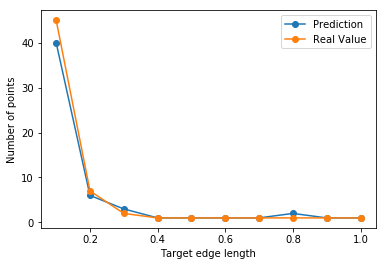

In [87]:
Neural_net_prediction=plt.plot(np.linspace(.1,1,10),prediction,'-o',label='Prediction')
Real_value=plt.plot(np.linspace(.1,1,10),real_number_of_points,'-o',label='Real Value')
plt.xlabel('Target edge length')
plt.ylabel('Number of points')
plt.legend()

In [90]:
a_tensor=torch.Tensor([0,1,2,3])

In [93]:
a_variable=Variable(a_tensor)

In [99]:
y=lambda x: x+3

In [100]:
my_function=y(a_variable)

In [101]:
my_function.backward()

RuntimeError: element 0 of variables does not require grad and does not have a grad_fn